In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  





from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV




### Load Data:

In [2]:
# load training data prepared previously

df_train = pd.read_csv('data/train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [3]:
# load test data prepared previously

df_test = pd.read_csv('data/test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


### Regression Modelling:

Segment training and test data into features dataframe and labels series.  

To make it easy to train models on different set of features, a variable to hold the set of features required was used to subset the original dataframes

In [4]:
#Prepare data for regression model

# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_adxf = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
                 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7',
                 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 
                 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 
                 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

# features with low or no correlation with regression label
features_lowcr = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# features that have correlation with regression label
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

# a variable to hold the set of features to experiment with
features = features_orig


X_train = df_train[features]
y_train = df_train['ttf']

X_test = df_test[features]
y_test = df_test['ttf']

Create a helper function to calculate regression metrics

In [5]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

Create a helper function to plot the oefficients weights or feature importance

In [6]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    
    """Plot regression coefficients weights or feature importance.
    
    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'
        
    Returns:
        plot of either regression coefficients weights or feature importance
        
    
    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None
    

Create a helper function to plot the regression residuals

In [7]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    
    """Print the regression residuals.
    
    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data
        
    Returns:
        Plot of regression residuals
    
    """
    
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()
    
    

Using the above functions let us model and evaluate some regression algorithms

In [8]:
#try linear regression

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics


R^2 training: 0.580, R^2 test: 0.405


,Linear Regression
Root Mean Squared Error,32.041095
Mean Absolute Error,25.591780
R^2,0.405495
Explained Variance,0.665297


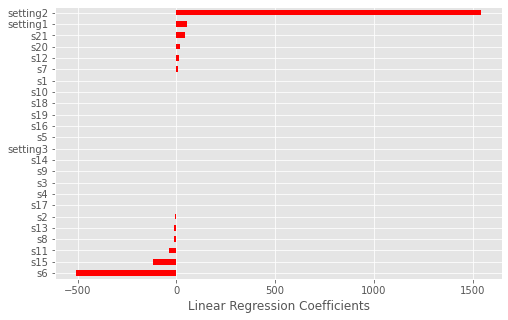

In [9]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

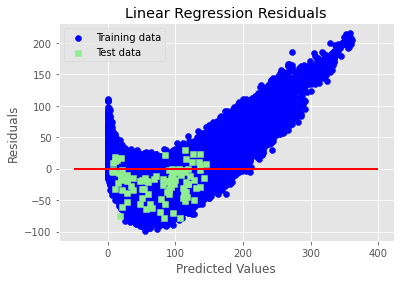

In [10]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

In [11]:
#try LASSO

lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics


R^2 training: 0.579, R^2 test: 0.408


,LASSO
Root Mean Squared Error,31.966099
Mean Absolute Error,25.551808
R^2,0.408275
Explained Variance,0.668206


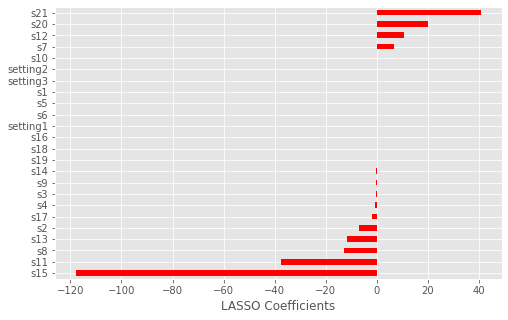

In [12]:
plot_features_weights('LASSO', lasso.coef_, X_train.columns, 'c')

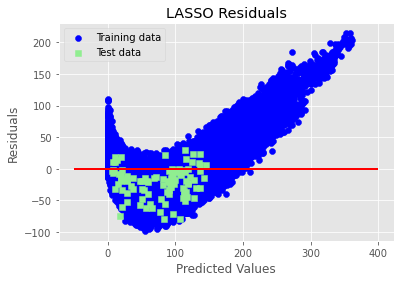

In [13]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)

In [14]:
#try ridge

rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.580, R^2 test: 0.408


,Ridge Regression
Root Mean Squared Error,31.965740
Mean Absolute Error,25.544620
R^2,0.408289
Explained Variance,0.667607


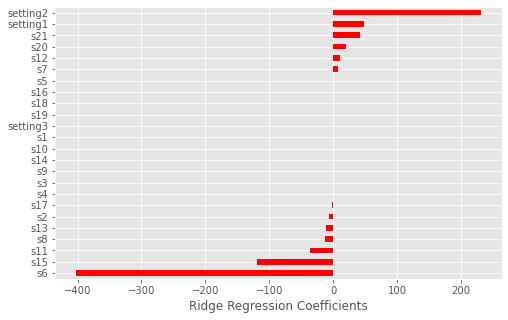

In [15]:
plot_features_weights('Ridge Regression', rdg.coef_, X_train.columns, 'c')

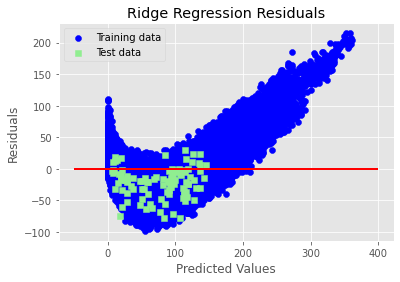

In [16]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)

In [17]:
#try Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics



R^2 training: 0.627, R^2 test: 0.414


,Polynomial Regression
Root Mean Squared Error,31.814768
Mean Absolute Error,24.186406
R^2,0.413865
Explained Variance,0.637227


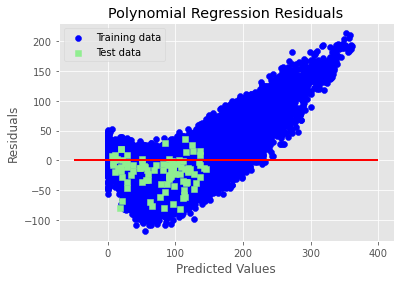

In [18]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

Polynomial Regression has scored better than linear models

In [19]:
#try Decision Tree regressor

#dtrg = DecisionTreeRegressor(max_depth=8, max_features=5, random_state=123) # selected features
dtrg = DecisionTreeRegressor(max_depth=7, random_state=123)
dtrg.fit(X_train, y_train)

y_test_predict = dtrg.predict(X_test)
y_train_predict = dtrg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

dtrg_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_test_predict)
dtrg_metrics

R^2 training: 0.625, R^2 test: 0.403


,Decision Tree Regression
Root Mean Squared Error,32.095349
Mean Absolute Error,24.319068
R^2,0.403480
Explained Variance,0.632767


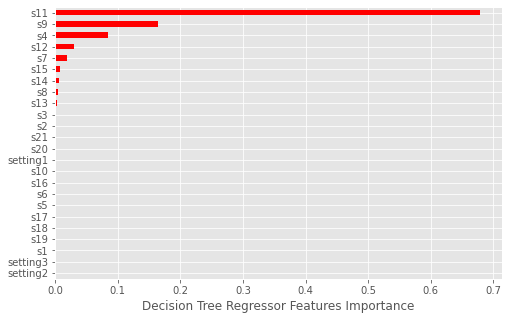

In [20]:
plot_features_weights('Decision Tree Regressor', dtrg.feature_importances_, X_train.columns, 't' )

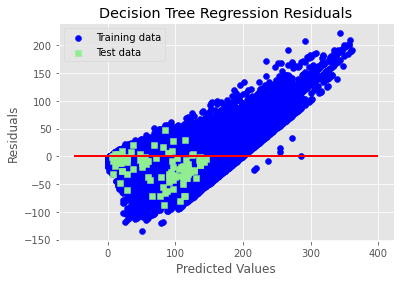

In [21]:
plot_residual('Decision Tree Regression', y_train_predict, y_train, y_test_predict, y_test)

Let us try to visualize the tree constucted by the Decision Tree regressor

In [22]:
!pip install graphviz

In [23]:
# view the constructed decision tree

# import graphviz

# export_graphviz(dtrg, out_file="fig/mytree.dot", feature_names=X_train.columns)
# with open("fig/mytree.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

Let us try some feature selection on decsion tree, for example Recursive Feature Elimination (RFE)

Optimal number of features : 5
The selected features are: ['s4', 's7', 's9', 's11', 's12']


C:\Users\91958\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


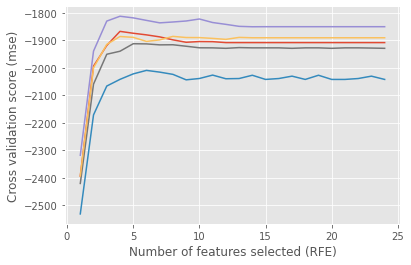

In [25]:
# try recursive feature elimination

kfold = model_selection.KFold(n_splits=5, random_state=10,shuffle=True)

dtrg = DecisionTreeRegressor(max_depth=7)

rfecv = RFECV(estimator=dtrg, step=1, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

sel_features = [f for f,s in zip(X_train.columns, rfecv.support_) if s]
print('The selected features are: {}'.format(sel_features))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected (RFE)")
plt.ylabel("Cross validation score (mse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Test the same model with the selected features

In [26]:
# Decition Tree with selected features

#trnsform train and test data
X_train_trn = rfecv.transform(X_train)
X_test_trn = rfecv.transform(X_test)

print(X_train.shape)

dtrg = DecisionTreeRegressor(max_depth=7)

dtrg.fit(X_train_trn, y_train)

y_test_predict = dtrg.predict(X_test_trn)

dtrg_fs_metrics = get_regression_metrics('Decision Tree: Selected Features', y_test, y_test_predict)

#combine decision tree results: All features and selected features
dtr_metrics = pd.concat([dtrg_fs_metrics,dtrg_metrics], axis=1)

dtr_metrics

(20631, 24)


,Decision Tree: Selected Features,Decision Tree Regression
Root Mean Squared Error,34.212392,32.095349
Mean Absolute Error,25.866117,24.319068
R^2,0.322191,0.403480
Explained Variance,0.593892,0.632767


Model performance using only 5 top important features is comparable to using all 24 features.  

What is % importance of these 5 features?

In [27]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(sel_features, dtrg.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

importances.sort_values(by='Importance', ascending=False)

,Importance
s11,0.682967
s9,0.168857
s4,0.091236
s12,0.033993
s7,0.022948


In [28]:
#try Random Forest

#rf = RandomForestRegressor(n_estimators=100, max_features=2, max_depth=4, n_jobs=-1, random_state=1) # selected features
rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4, n_jobs=-1, random_state=1) # original features
#rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=7, n_jobs=-1, random_state=1) # orig + extrcted 

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.594, R^2 test: 0.525


,Random Forest Regression
Root Mean Squared Error,28.634253
Mean Absolute Error,23.167130
R^2,0.525198
Explained Variance,0.767320


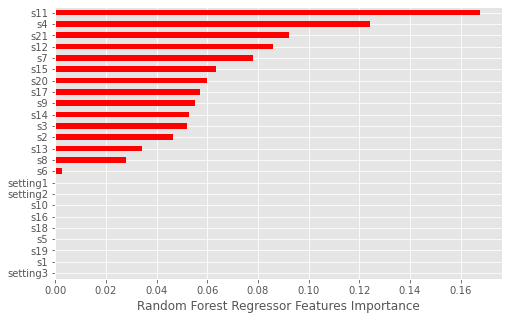

In [29]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

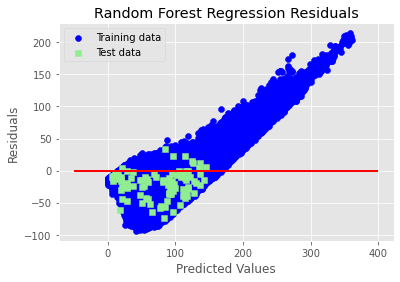

In [30]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

regression residuals were not randomly spread across the average value of the residuals. This could be improved by fixing the data (e.g. outliers, resampling) or model parameters tuning.

Let us view predicted values

In [31]:
# view predictions vs actual

rf_pred_dict = {
                'Actual' : y_test,
                'Prediction' : y_test_predict
            }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Actual,112.000000,98.000000,69.000000,82.000000,91.00000,93.000000,91.000000,95.000000,111.00000,96.000000,...,38.000000,20.000000,85.00000,55.000000,128.000000,137.000000,82.000000,59.000000,117.000000,20.00000
Prediction,151.578408,119.268513,74.415647,96.470907,112.59338,130.279445,128.114019,100.692144,116.11839,127.369752,...,40.976045,33.031218,51.39622,64.318328,143.657061,159.663783,100.027659,103.182456,157.063688,35.62655


#### Compare all regression models tested

In [32]:
#regression metrics comparison before feature engineering

reg_metrics_bfe = pd.concat([linreg_metrics, lasso_metrics, rdg_metrics, dtrg_metrics, polyreg_metrics, rf_metrics], axis=1)
reg_metrics_bfe

,Linear Regression,LASSO,Ridge Regression,Decision Tree Regression,Polynomial Regression,Random Forest Regression
Root Mean Squared Error,32.041095,31.966099,31.965740,32.095349,31.814768,28.634253
Mean Absolute Error,25.591780,25.551808,25.544620,24.319068,24.186406,23.167130
R^2,0.405495,0.408275,0.408289,0.403480,0.413865,0.525198
Explained Variance,0.665297,0.668206,0.667607,0.632767,0.637227,0.767320


__Regression Summary:__  

In accordance with our analysis in the data exploratory phase, non-linear regression models like Polynomial and Random Forest performed better than linear models like OLS, LASSO and Ridge regression. Random Forest clearly outperformed other models scoring RMSE of 28.63 cycles, i.e. the model predicts TTF within average error range of ±28.63 cycles.

The hyper-parameter tuning for the Random Forest Regressor, LASSO, and Ridge models was done manually, but Grid Search or Random Search with Cross Validation could be used for better processing.



In [55]:
# nural net

from sklearn.neural_network import MLPRegressor
nregr = MLPRegressor(random_state=1,hidden_layer_sizes=(128,), max_iter=500)
nregr.fit(X_train, y_train)
y_test_predict = nregr.predict(X_test)
y_train_predict = nregr.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

nregr_metrics = get_regression_metrics('nural net', y_test, y_test_predict)
nregr_metrics


R^2 training: 0.418, R^2 test: 0.550


,nural net
Root Mean Squared Error,27.869181
Mean Absolute Error,23.603773
R^2,0.550232
Explained Variance,0.645595
